# Digit Classifier Using MNIST #

MNIST is a dataset of low res images of hand written digits.
In this notebook I will explore the math and implement from scratch in python different nueral network structures and compare their performance.
 
Data Structure and Notation:
* 28 x 28 pixel images, 784 pixels
* $m$ training images
* $X$ is a matrix with dimensions $m$ by 784 
    * $X^{T}$ is used for input into nueral network model

 ## Basic NN Structure ##
input layer: 784 nodes \
hidden layer: 10 nodes \
output layer: 10 nodes for 10 classes or digits 

## Forward Propagation ##
Forward propagation is the process of transforming our input data into our output data.

The input layer is simply a matrix of our raw training data. \
Input Layer Definition:
* $A^{[0]} = X\space\space\text{with dimensions } 784\space \text{x} \space m$

The hidden layer values are obtained by a linear transformation of the input layer followed by a non-linear transformation or activation of the transformed input data. \
We are using the rectified linear unit or ReLU as the activation function for our hidden layer. 

$\text{RelU}(x) = \{x \hspace{0.5em} \text{if} \hspace{0.5em} x > 0, \hspace{1em} 0 \hspace{0.5em} \text{if} \hspace{0.5em} \le 0\}$ 

Hidden Layer Definition:
* $Z^{[1]} = w^{[1]} \cdot A^{[0]} + b^{[1]}$ (Unactivated: linear transformation of input layer)
* $A^{[1]} = g(Z^{[1]}) = \text{ReLu}(Z^{[1]})$ (Activated: ReLU transformation of linear transformation)

The output layer works similarly to the hidden layer but with an output specific activation function. \
The hidden layer is linearally transformed and this time we use a softmax as an activation function to convert our transformed values into probabilities. 
The softmax essentially calculates the contribution of each not to the total output vector.

$\text{softmax}(x) = \dfrac{e^{x_{i}}}{\sum_{i=1}^{k} e^{x_{i}}}$

* $Z^{[2]} = w^{[2]} \cdot A^{[2]} + b^{[2]}$ (Unactivated: linear tranformation of hidden layer)
* $A^{[2]} = \text{softmax}(Z^{[2]})$ (Activated: probabilities of input being a given class)

## Back Propagation ##
Back Propagation is the process we use to learn the weights and biases in the forward propagation process. \
It works by finding the error in the weights, biases, and predictions working backward from the output layer. 

First step is to find the error of the output layer by subtracting the classes from our output layer matrix \
Y is the digit pictured in each image in the training set. Y is a one-hot encoded 10 by m matrix. 

* $dZ^{[2]} = A^{[2]} - Y$ (error of predictions)

The next step is to find the error associated with weights and biases used in the linear transformation in the second layer.

* $dw^{[2]} = \frac{1}{m} dZ^{[2]} \cdot A^{[1]T}$ (contributions of layer 2 weights to prediction error)
* $db^{[2]} = \frac{1}{m} \sum dZ^{[2]}$ (contributions of layer 2 biases to prediction error)

Repeat this process to find error of weights and biases in the first layer. Must undo activation function \
$g`$ is the derivative of the activation function
* $dZ^{[1]} = w^{[2]T} dZ^{[2]} \cdot g`(Z^{[1]})$ (error of unactivated layer 2 nodes)
* $dw^{[1]} = \frac{1}{m} dZ^{[1]} X^T$ (contribution of weights to layer 2 error)
* $db^{[1]} = \frac{1}{m} \sum dZ^{[1]}$ (contribution of biases to layer 2 error)

## Weight and Bias Update ##
Weights and biases are then updated after calculating their errors in backpropagation. \
The new values are generated by subtracting the error multiplied by a learning rate parameter. \
The learning rate $\alpha$ is a user defined constant that modifies how much the weights and biases are changed in each cycle

* $w^{[1_{}]}_{new} = w^{[1]} - \alpha dw^{[1]}$
* $b^{[1]}_{new} = b^{[1]} - \alpha db^{[1]}$
* $w^{[2]}_{new} = w^{[2]} - \alpha dw^{[1]}$
* $b^{[2]}_{new} = b^{[2]} - \alpha db^{[2]}$

This process of using forward propagation to make predictions follow by backward propagation to find the error and "learn" new weights \
is repeats till our predictions reach reach some sort of convergence. This training process in known as gradient descent. 





(2051, 60000, 28, 28)


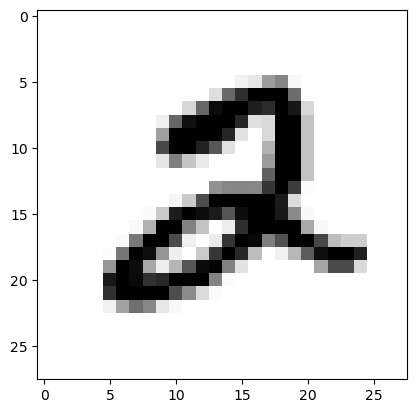

In [81]:
import sys
import os
import struct
import numpy as np
import pandas as pd 
from matplotlib import pyplot as plt

datpath = "../../data/mnist"
image_size = 28
num_images = 10

# open training data which is 
f = open(f"{datpath}/train-images-idx3-ubyte/train-images-idx3-ubyte", mode = "rb")
# first 16 bytes hold training image metadata
print(struct.unpack(">IIII", f.read(16)))
buf = f.read(image_size * image_size * num_images)
data = np.frombuffer(buf, dtype = np.uint8).astype(np.float32)
data = data.reshape(num_images, image_size, image_size, 1)
image = np.asarray(data[5]).squeeze()
plt.imshow(image, cmap = plt.cm.gray_r)



In [59]:
#### ACTIVATION FUNCTIONS ####
def ReLU(vec: np.array):
    return np.maximum(0, vec)

def deriv_ReLU(vec: np.array):
    return vec > 0

def softmax(vec: np.array):
    return np.exp(vec) / np.sum(np.exp(vec))



##### NN CLASSES #######

class Layer(object):

    def __init__(self, layer_id, input_size, node_count, activation_func, layer_type = "hidden"):

        # Layer metadata
        self.layer_id = layer_id
        self.node_count = node_count
        self.layer_type = layer_type
        self.activation_func = activation_func
        # random init of weights and biases
        self.weights = np.random.rand(size = (node_count, input_size))
        self.biases = np.random.rand(size = (node_count, 1))
    
    def transform(self, input_dat: np.array):

        lin_transform = self.weights.dot(input_dat) + self.biases
        self.unactivated_node_values = lin_transform
        self.node_values = self.acivation_func(lin_transform) 

        return self.node_values

    def update_weights_n_biases(self, weight_error, bias_error, learning_rate):
        pass


class TwoLayerNN(object):

    def __init__(
            self,
            train_dat: np.array,
            train_labels: np.array,
            test_dat: np.array,
            test_labels: np.array,
            hidden_nodes: int,
            output_nodes: int,
            learning_rate: float,
        ):

        self.train_dat = train_dat
        self.train_labels = train_labels
        self.test_dat = test_dat
        self.test_labels = test_labels
        self.learning_rate = learning_rate
        # layer init
        self.hidden_layer = Layer("hidden", hidden_nodes, self.traind_dat.shape[0], activation_func = ReLU)
        self.output_layer = Layer("out", output_nodes, hidden_nodes, activation_func = softmax, layer_type = "out")

    def forward_prop(self):
        hidden_transformed = self.hidden_layer.transfrom(self.train_dat)
        out = self.output_layer.transform(hidden_transformed)
        self.out = out

    def backward_prop(self):

        m = self.train_dat.shape[1]
        # prediction error
        dZ_o = self.out - "one_hot(self.train_labels)"
        dw_o = (1 / m) * dZ_o.dot(self.hidden_layer.node_values.T) 
        db_o =  np.sum(dZ_o, 2) / m
        # hidden layer error
        dZ_h =  self.output_layer.weights.T.dot(dZ_o) * deriv_ReLU(self.hidden_layer.unactivated_node_values)
        dw_h = (1 / m) * dZ_h.dot(self.train.T)
        db_h =  np.sum(dZ_h) / m
        # update weights and biases from error components
        self.hidden_layer.update_weights_n_biases(dw_h, db_h, self.learning_rate)
        self.output_layer.update_weights_n_biases(dw_o, db_o, self.learning_rate)

    def train(self):
        pass

    def test(self):
        pass



array([0.08807971, 0.08807971, 0.08807971, 0.08807971, 0.08807971,
       0.08807971, 0.08807971, 0.08807971, 0.08807971, 0.08807971,
       0.01192029, 0.01192029, 0.01192029, 0.01192029, 0.01192029,
       0.01192029, 0.01192029, 0.01192029, 0.01192029, 0.01192029])

(10, 28, 28, 1)

In [78]:
data.flatten().shape

(7840,)